# RL homework 3

-------------------------------


**Name:** Oliver Wesely 

**SN:** 18057603

-----------------------------------


**Due date:** *April 8, 2019, 9:00 am*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

# The Assignment

### Objectives

#### Part 1:
You will analyse the learning dynamics of a simple MRP with linear function approximation **[30 pts]**

#### Part 2:
You will use Python to implement several reinforcement learning algorithms and you will answer a few question about the performance of these algorithms **[55pts]**.

#### Part 3:

Analyse optimal values and policies in a small partially observable environment **[15pts]**.



# Setup

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Gridworlds

In [0]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest",cmap="pink")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


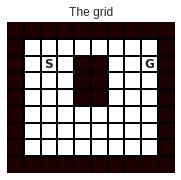


An alternative grid world


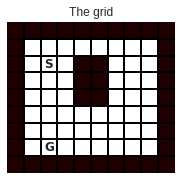


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


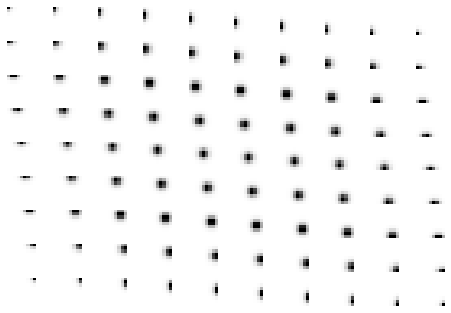

In [0]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)), interpolation='nearest')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  plt.hold('on')

  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Linear Function Approximation

## Q1

We will analyze a simple Markov reward process (an MRP is an MDP without actions or, equivalently, with just 1 action in each state).  

- It consists of two states. 
- The reward is zero everywhere. 
- When we are in state $s_0$, we always transition to $s_1$. 
- If we are in state $s_1$, there is a probability $p$ of terminating, after which the next episode starts in $s_0$ again.  With a probability of $1 - p$, we transition from $s_1$ back to itself again. 
- The discount is $\gamma = 1$ on non-terminal steps.




#### [1pt] Question 1.1
What is the optimal value in each state?

> The optimal value of each state $(s_0,s_1)$ is 0. This is the case because the rewards is zero everywhere. To see that we can just solve the bellman equationto get the optimal value by inerting 0 rewards.

#### [1pt] Question 1.2
Instead of a tabular representation, consider a single feature $\phi$, which takes the values $\phi(s_0) = 1$ and $\phi(s_1) = 3$.  Now consider using linear function approximation, where we learn a value $\theta$ such that $v_{\theta}(s) = \theta \times \phi(s) \approx v(s)$, where $v(s)$ is the true value of state $s$.  What is the optimal value of $\theta$?

>  The optimal value of $\theta$ is still 0, as in Question 1.1. (van Hasselt H., Doron Y., Strub F., Hessel M., Sonnerat N., Modayil J., "Deep Reinforcement Learning and the Deadly Triad", 2018, CoRR)

### Online updates

We now assume we generate data sampling from the MRP, starting each episode in state $s_0$ and following the environment's dynamics until episode termination. Updates are then performed online on each newly generated transition.

#### [5pts] Question 1.3
Suppose $\theta_0 = 1$, and suppose we update this parameter online with TD(0) with a step size of $\alpha = 0.1$.  What is the expected value of $\mathbb{E}[ \theta_T ]$ if we step through the MRP until it terminates after the first episode, as a function of $p$?  (Note that $T$ is random.)

From the lecture we know our TD(0) update of the parameter $\theta$:

$\theta_{t+1}=\theta_t+\alpha(R_{t+1}+\gamma v_{\theta}(S_{t+1})-v_{\theta}(S_t)) \nabla v_{\theta}(S_t)$

The first update, $s_0$ to $s_1$ is fixed and therefore the expectation ommited, as the probability is equal to 1:

$\theta_{1}=\theta_0+\alpha(R_{1}+\gamma v_{\theta}(s_{1})-v_{\theta}(s_0)) \nabla v_{\theta}(s_0)$
$\theta_{1}=\theta_0+\theta_0 \alpha(0+3-1) 1$
$\theta_1=\theta_0(1+2\alpha)$

After state 1 we have two options: with probability 1-p we remain in state $s_1$ and with probability p we terminate.

So we first look at the update, $s_1$ to $s_1$:

$\theta_{t+1}=\theta_t+\alpha(R_{t+1}+\gamma v_{\theta}(S_{1})-v_{\theta}(S_{1})) \nabla v_{\theta}(S_1)$
$\theta_{t+1}=\theta_t+\alpha(0+\underbrace{v_{\theta}(s_{1})-v_{\theta}(s_{1})}_{=0}) \nabla v_{\theta}(s_1)$
$\theta_{t+1}=\theta_t$

If it terminates, we have $\gamma=0$, so:

$\theta_{t+1}=\theta_t+\alpha(0+0-3\theta_t) 3$
$\theta_{t+1}=\theta_t (1 -9\alpha)$

With these updatex we can now calculate $\theta_T$ for some arbitrary T. So the termination is at step T, therefore:

$\theta_T=\theta_{T-1}(1-9\alpha)$

As we have no update from state 1 to state (T-1), we know:

$\theta_T=\theta_1(1-9\alpha)$,

finally we only have to insert our first update from state 0 to state 1:

$\theta_T=\theta_0(1+2\alpha)(1-9\alpha)$

With $\theta_0=1$ and $\alpha=0.1$ we get:

$\theta_T=1(1+2*0.1)(1-9*0.1)$
$\theta_T=1.2*0.1=0.12$,

with probability 1.

So $\mathbb{E}[\theta_T]=\theta_T=0.12$

#### [5pts] Question 1.4
If $p=0.2$, how many episodes does it take, starting from $\theta_0 = 1$, until $| v(s) - \mathbb{E}[v_{\theta}(s)] | < 0.1$ for all $s$, where the expectation is over the expected updates to $\theta$?


$\mathbb{E}[v_{\theta}(s)]=\mathbb{E}[\theta]\mathbb{E}[\phi(s)]=0.12 * 3$

So we need to find the minimum n which satisfies $0.12^n*3<0.1$, which is:
$n=ceiling((log(0.1/3)/log(0.12))=ceiling(1.6)=2$

#### Changing the data distribution
Now suppose we use TD to update the parameters, but instead of using the online data, we assume we can actively sample a transition from any of the two states, and on each training step we sample a transition from the first state with probability $\beta$ or instead a transition from the second state with probability $1-\beta$.

#### [3pts] Question 1.5

What is the value of $\mathbb{E}[\theta_n]$, as a function of $n$, $p$ and $\beta$?


As we sample a transition from any of the two states, we start $s_0$ with probability $\beta$  and an expected reward of, using the solution from question 1.3:

$\mathbb{E}[v_{s_0}|S=s_0] = \theta_0(1+2\alpha)=1.2$

Whereas looking at $s_1$ we have to consider the probability of termination or not:

$\mathbb{E}[v_{s_1}|S=s_1] = p\theta_0(1-9\alpha) + (1-p)\theta_0$
$\mathbb{E}[v_{s_1}|S=s_1] = 0.1p +1-p=1-0.9p$

We can model $\mathbb{E}[\theta_n]$ as a Binomial with probability $\beta$ and n steps, following:

$ \mathbb{E}(\theta_n) = \sum_{k}^{n} {n \choose k}\beta^{k}(1.2)^{k} (1-\beta)^{n-k}(1-0.9p)^{n-k} = \sum_{k}^{n} {n \choose k}(1.2\beta)^{k} ((1-\beta)(1-0.9p))^{n-k} $
$ \mathbb{E}(\theta_n) = (1.2\beta + (1-\beta)(1-0.9p))^n$

Reexpressing the sum by using binomial expansion properties.

#### [5pts] Question 1.6

When does $\theta$ converge to the true solution? Give your answer as a function of $\beta$ and $p$.

We want $\theta$ to converge, therefore we need to sample $\beta \propto p$. The proportionality exists which is all we need to obtain convergence. (Tsitsiklis J. N., van Roy B., "An analysis of Temporal-Difference Learning with Function Approximation", 1997, IEEE)

As we already know:

$ \mathbb{E}(\theta_n) = (1.2\beta + (1-\beta)(1-0.9p))^n$

We know that $\theta$ converges to 0 only when $|\mathbb{E}[\theta_n]|<1$.

As $p,\beta \in [0,1]$ we get that:

$1.2\beta \in [0,1.2]$
$(1-\beta)(1-0.9p) \in [0,1]$

$|\mathbb{E}[\theta_n]|<1$

$(1.2\beta + (1-\beta)(1-0.9p))^n<1$

$1.2\beta + (1-\beta)(1-0.9p)<1$

$1.2\beta + 1 -\beta -0.9p(1-\beta) <1$

$0.2\beta<0.9p(1-\beta)$

$\frac{0.2\beta}{0.9(1-\beta)}<p$




#### [5pts] Question 1.7

Why doesn't it always converge?

(Sutton R. S., Barto A. G., p. 215, "Reinforcement Learning: An Introduction") and we have off-policy training and because we are using function approximation and TD methods we  also have properties of the Deadly Triad.


Online sampling methods which not sample frequencies natural to the Markov chain do not converge (Tsitsiklis J. N., van Roy B., "An analysis of Temporal-Difference Learning with Function Approximation", 1997, IEEE) And we sample our states with another distribution than we use within the MRP.


#### [5pts] Question 1.8
Describe one way to change the algorithm to obtain convergence of $\theta$, for any $p$, without changing the sampling or the value function (which should remain as $v_{\theta}(s) = \theta \times \phi(s)$).  Note that the sampling is not sequential, so for instance you cannot add 'memory of the previous state', or anything like that.

We only need to choose a $\gamma$ smaller than 1, because the geometric series converges: $\sum_{i=0}^\infty \gamma ^i= \frac{1}{1-\gamma}$, if $|\gamma|<1$.

# Part 2: Planning

## 2.1: Implement Agents

We are going to implement 5 agent:
- Online Tabular Q-learning
- Tabular Experience Replay
- Tabular Dyna-Q (with a Tabular model)
- Experience Replay with linear function approximation
- Dyna-Q with linear function approximation (with a linear model)

All agent you implement in this section must share the agent interface

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`. All agents should be in pure Python - do not use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Question 2.1.1
**[2 pts]** 

Implement a trainable **tabular model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

Given that the environment is deterministic and tabular the model will basically reduce to a simple lookup table.

In [0]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.S = np.zeros(shape=(number_of_states,number_of_actions),dtype='int8')
    self.Rew = np.zeros(shape=(number_of_states,number_of_actions),dtype='float32')
    self.Gamma = np.zeros(shape=(number_of_states,number_of_actions),dtype='float32')
    return

  def next_state(self, s, a):
    return self.S[s,a]
  
  def reward(self, s, a):
    
    return self.Rew[s,a]

  def discount(self, s, a):
    
    return self.Gamma[s,a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    
    self.S[state,action] = next_state
    self.Rew[state,action] = reward
           
    self.Gamma[state,action] = discount
    return


### Question 2.1.2

**[3 pts]** 

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward, discount and next state will all be a linear function of the state.
* $\text{s'} = T_a s$
* $\text{r'} = R_a s$
* $\text{g'} = G_a s$

Where $T_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $R_a$ and $G_a$are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by gradient descent. Write down the update to the parameters of the models and implement the update in the model below.



In [0]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.Trans = np.zeros(shape=(number_of_actions,number_of_features,number_of_features),dtype='float32')
    self.Rew = np.zeros(shape=(number_of_actions,number_of_features),dtype='float32')
    self.Gamma = np.zeros(shape=(number_of_actions,number_of_features),dtype='float32')
    return

  def next_state(self, s, a):
          
    return np.matmul(self.Trans[a,:,:],s) 
  
  def reward(self, s, a):
    return np.matmul(self.Rew[a,:],s)

  def discount(self, s, a):
    return np.matmul(self.Gamma[a,:],s)
  
  

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    self.Trans[action,:,:] = self.Trans[action,:,:] + step_size * np.matmul((next_state - self.next_state(state,action)).reshape(-1,1) , state.reshape(1,-1))
          
    self.Rew[action,:] = self.Rew[action,:] + step_size * (reward - self.reward(state,action)) * state
           
    self.Gamma[action,:] = self.Gamma[action,:] + step_size * (discount - self.discount(state,action)) * state
    return

### Question 2.1.3

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning update with the most recently sampled transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [0]:
class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._state = initial_state
    self._action = 0
    
    self.Qval = np.zeros(shape=(number_of_states, number_of_actions)) 
    self.step_size = step_size
    self.policy = behaviour_policy
    
    self.offline_updates = num_offline_updates
    self.Replay_buffer =[]
    self.number_of_actions = number_of_actions
    return
  
  @property
  def q_values(self):
    return self.Qval

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self.Replay_buffer.append((s,a,next_state,r,g))
    self.Qval[s,a] = self.Qval[s,a] + self.step_size * (r + g * np.max(self.Qval[next_s]) - self.Qval[s,a])
    
    i = np.floor((len(self.Replay_buffer)*np.random.rand(self.offline_updates)))
    
    for j in range(len(i)):
      state_re, act_re, next_state_re, rew_re, gamma_re = self.Replay_buffer[(int)(i[j])]
                
      self.Qval[state_re, act_re] = self.Qval[state_re, act_re]+ self.step_size * (rew_re + gamma_re*np.max(self.Qval[next_state_re]) - self.Qval[state_re,act_re])
      
    self._action = self.policy(self.Qval[next_s])
    self._state = next_s
    
    return self._action



### Question 2.1.4

**[5 pts]**

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [0]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._state = initial_state
    self._action = 0
    self.Qval = np.zeros((number_of_states, number_of_actions))
    self.step_size = step_size
    self.policy = behaviour_policy
    self.offline_updates = num_offline_updates
    
    self.Replay_buffer = []
    self.number_of_actions = number_of_actions
    self.model = TabularModel(number_of_states, number_of_actions)
    return 
    
  @property
  def q_values(self):
    return self.Qval

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self.Replay_buffer.append((s,a))
    self.Qval[s,a] = self.Qval[s,a] + self.step_size*(r + g*np.max(self.Qval[next_s]) - self.Qval[s,a])
    
    self.model.update(s,a,r,g,next_s)
           
    i = np.floor((len(self.Replay_buffer)*np.random.rand(self.offline_updates))) # Had to use floor to make these into integers
    for j in range(self.offline_updates):
      state_re, act_re = self.Replay_buffer[(int)(i[j])]
      rew_re, gamma_re, next_state_re = self.model.transition(state_re, act_re)
      
      self.Qval[state_re, act_re] = self.Qval[state_re, act_re] + self.step_size*(rew_re + gamma_re*np.max(self.Qval[next_state_re]) - self.Qval[state_re, act_re])
      
               
    self._action = self.policy(self.Qval[next_s])
    self._state = next_s
    
    return self._action


### Question 2.1.5

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.

In [0]:
class FeatureExperienceQ(ExperienceQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureExperienceQ, self).__init__(number_of_actions=number_of_actions, *args, **kwargs)
    self.trans = np.zeros(shape=(number_of_actions,number_of_features), dtype = 'float32')
    return 

  def q(self, state):
    return np.matmul(self.trans, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self.Replay_buffer.append((s,a,next_state,r,g))
    
    
             
    self.trans[a,:] += self.step_size * (r + g*np.max(np.matmul(self.trans,next_s))-np.matmul(self.trans,s)[a]) * s
           
    i = np.floor((len(self.Replay_buffer)*np.random.rand(self.offline_updates))) # Had to use floor to make these into integers
    for j in range(self.offline_updates):
      state_re, act_re, next_state_re, rew_re, gamma_re = self.Replay_buffer[(int)(i[j])]
      self.trans[act_re,:] = self.trans[act_re,:] + self.step_size * (rew_re + gamma_re*np.max(np.matmul(self.trans,next_state_re))-np.matmul(self.trans,state_re)[act_re]) * state_re
      
    self._action = self.policy(np.matmul(self.trans,next_s))
    self._state = next_s
    return self._action


### Question 2.1.6

**[5 pts]**

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [0]:
class FeatureDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureDynaQ, self).__init__(number_of_actions=number_of_actions, *args, **kwargs)
    self.trans = np.zeros(shape=(number_of_actions,number_of_features), dtype = 'float32')
    self.model = LinearModel(number_of_features, number_of_actions)
    return 

  def q(self, state):
    return np.matmul(self.trans, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self.Replay_buffer.append((s,a))
    self.trans[a,:] = self.trans[a,:] + self. step_size * (r + g*np.max(np.matmul(self.trans,next_s))-np.matmul(self.trans,s)[a]) * s
    
    self.model.update(s,a,r,g,next_s,self.step_size)    
            
      
       
    i = np.floor((len(self.Replay_buffer)*np.random.rand(self.offline_updates))) # Had to use floor to make these into integers
    for j in range(self.offline_updates):
      state_re, act_re = self.Replay_buffer[(int)(i [j])]
      rew_re, gamma_re, next_state_re = self.model.transition(state_re, act_re)
             
      self.trans[act_re,:] = self.trans[act_re,:] + self.step_size * (rew_re + gamma_re*np.max(np.matmul(self.trans,next_state_re)) - np.matmul(self.trans, state_re)[act_re]) * state_re
      
    self._action = self.policy(np.matmul(self.trans,next_s))
    self._state = next_s
    
    return self._action


## 2.2: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

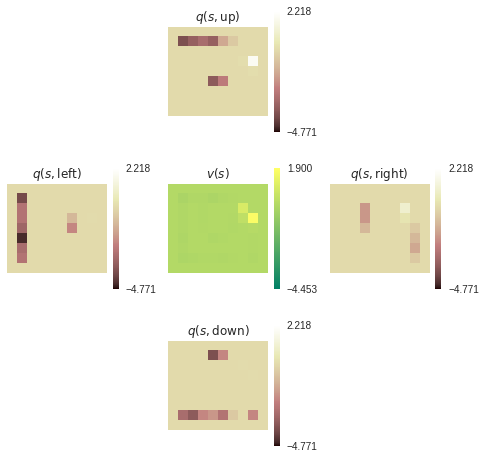

In [0]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

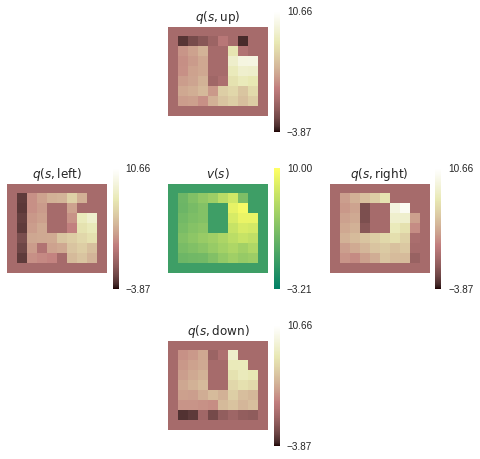

In [0]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

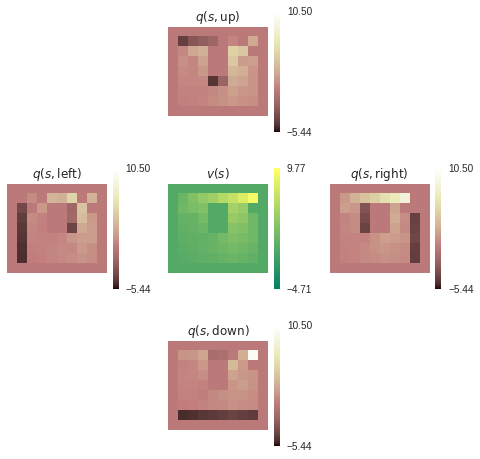

In [0]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Question 2.2.1

**[5 pts]**

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.

####Answer:

Looking at the estimates of online Q-learning we see that it looks different compared to the other agents, as the most state-action values are not learnt properly due the icremental update of q(s,a). Each episode only adds one step to the policy which makes the agent converging slowly and in this case only one step has been learned. Whereas ExperienceReplay and Dyna Q agents 
are both more data efficient then online Q-learning as they update offline and therefore have a faster convergence. ExperienceReplay in particular has state-action values gets better estimates of the state-action values, as it includes experience in its estimation. The Dyna Q agent also estimates a lot better than online Q-learning but is also different to ExperienceReplay as its update of the values is different as generating the latest transition model based.


### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $31,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

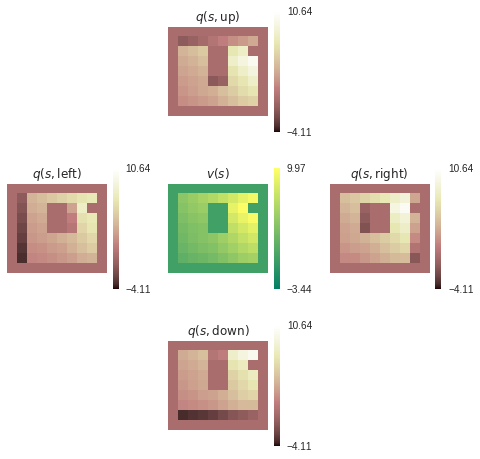

In [0]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(31e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

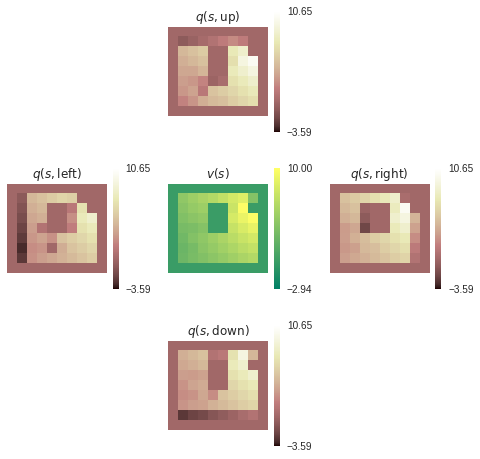

In [0]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

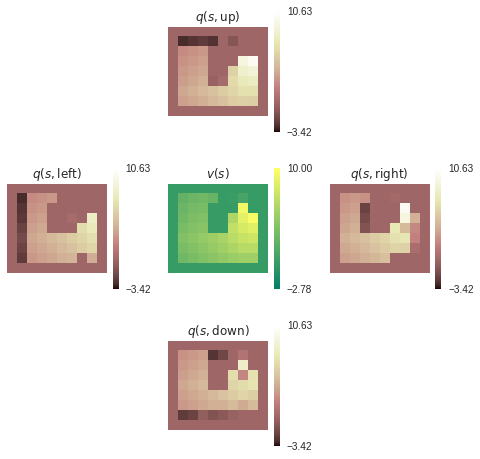

In [0]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Question 2.2.2

**[5 pts]**

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above this question are the same as those above question 2.2.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

How do the learnt values, and the relative performances, change, compared the the experiment above question 2.2.1?  Explain in at most 5 sentences.

####Answer:

As we don't care about data efficiency but only about the computational amount we use, we can see that online Q-learning performs now even better compared to both, ExperienceRelay and Dyna Q agents.This comes from the fact with more real world samples online Q-learning explores more and can update its state-action estimates more often to reach a significantly different result compared to the one before. Whereas ExperienceRelay and Dyna Q agents estimate the state-action pairs a little worse now, as there might be some biased offline updates, as there only exists a limited past observations to use, following a sample bias in the estimations.


### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


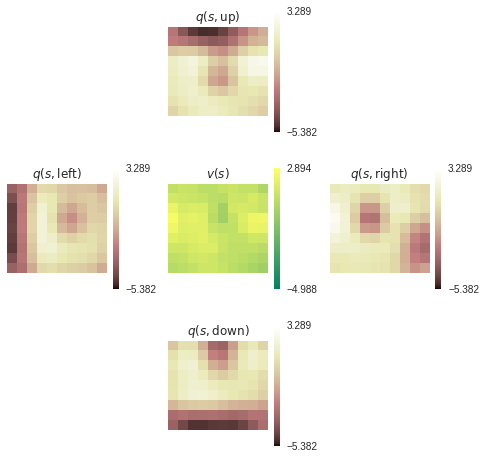

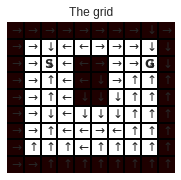

In [0]:
# OnlineQ
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


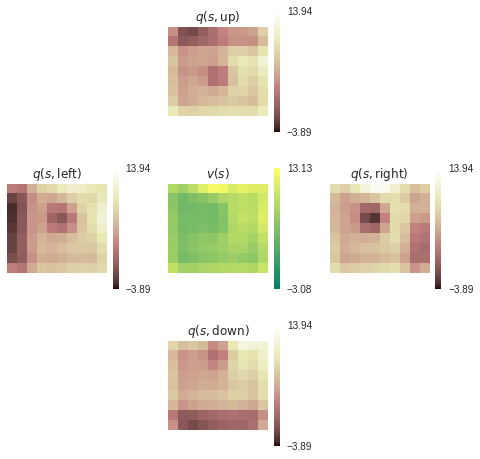

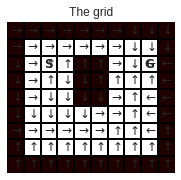

In [0]:
# Experience Replay
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


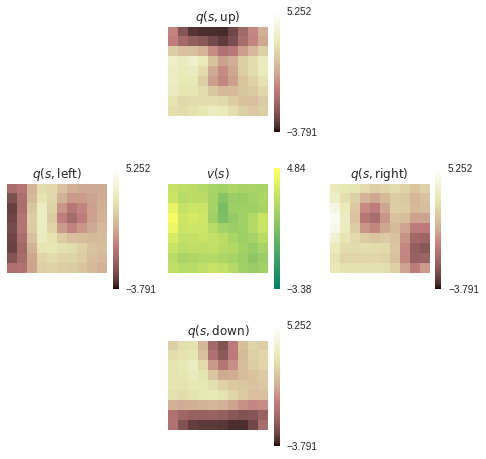

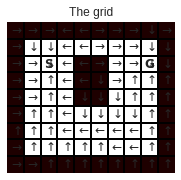

In [0]:
# DynaQ
grid = FeatureGrid()

agent = FeatureDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Question 2.2.3

**[5 pts]**

How do the values estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 2.2.1?

Explain the results in at most 5 sentences.

####Answer:

Using function approximation we get quite different estimations of our state action pairs which are a lot worse than in Q2.2.2 and 2.2.1 and a lot blurrier. Its not only the blurriness which makes the only big difference but actually walls in the grid get higher values as the agent can't really distinguish walls from normal states. The reason is that the state action pair updates are changing all parameters of the agent, including all states, following similar values, blurrier results and distinguish problems at walls.


### Question 2.2.4

**[5 pts]**

Inspect the policies derived by training agents with linear function approximation on `FeatureGrid'. 

How do they compare to the optimal policy?

####Answer:

As already said in Q2.2.3 all estimates are worse using linear function approximation agents. We can actually see different regions where the agents approximations get very high values, for instance if you look at the Q-learning results we can find some high values in the middle of the left border. And looking at ExperienceReplay in the middle of the top border. 

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

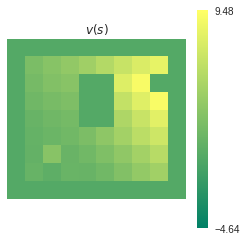

In [0]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

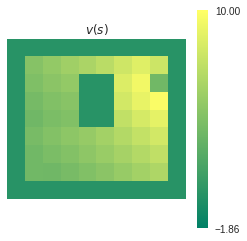

In [0]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

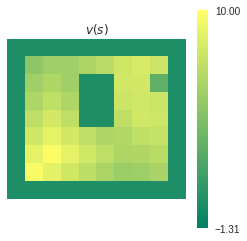

In [0]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Question 2.2.5

**[5 pts]**

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

#### Answer:

After training on the new goal location, which is in the bottom left corner, we can see that after 666 real world observations online Q-learning still has its highest values in the old goal location in the top right corner. But in the new goal location we already can see its value being brighter then all values surrounding it, so the agent begins to find the new goal location but still needs more observations to get updated results with higher values in the new goal location area. Instead if we look at the Dyna-Q agent values we already see a change of the bright areas from the top right corner to the bottom left corner wher the new goal location is. This change was fast, but since Dyna-Q uses only the most recent observations to update the q-values the agent catches the change of the goal quickly. Therefore we see a faster convergence to the new goal and new values using the Dyna Q agent, which can be said to be a rather flexible and easily adaptable agent compared to online Q-learning.


### Question 2.2.6

**[5 pts]**

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location, explain what you see.

#### Answer:

Looking at ExperienceReplay results we only see slightly difference compared to the situation without changing the goal at all. So we can say that the agent didn't even saw the new goal at all and might need a lot more observations to get the new goal. As the ExperienceReplay agent is sampling throughout historical observations the probability of sampling observations of the new goal is increasing rather slowly and takes longer to incorporate the new goal into our values.

Comparing this to Dyna Q we can see that Dyna Q already found the new goal pretty fast, as it is only sampling from the most recent observations and therefore the probability of using the new goal to update the values is a lot higher.

In total DynaQ is the agent catching up the new goal the fastest and rather is a more flexible and fast changable agent compared to the other two.


# Part 3: Policy Gradients

## 3.1. Policy Gradients

Consider a simple 2x2 gridworld.

- The agent starts in one of the top cells.
- Both cells on the bottom row are terminal.
- The bottom left cell provides a negative -1 reward.
- The bottom right cell provides a positive +1 reward.
- There is a fixed discount of 0.9


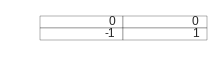

In [0]:
#@title MDP rewards

plt.figure(figsize=(3,0.7))
clust_data = np.array([[0, 0], [-1, 1]])
collabel=("col 1", "col 2", "col 3")
the_table = plt.table(cellText=clust_data, loc='center')
plt.axis('tight')
plt.axis('off')
plt.show()

### Question 3.1.1

**[1 pts]**

What are the *action values*  if the agent can perceive exactly in what state it is?


$Q(up|left\; state)=0.9^2=0.81$

$Q(down|left\; state)=-1$

$Q(right|left\; state)=0.9$

$Q(left|left\; state)=0.9^2=0.81$

$Q(up|right\; state)=0.9$

$Q(down|right\; state)=1$

$Q(right|right\; state)=0.9$

$Q(left|right\; state)=0.9^2=0.81$


### Question 3.1.2

**[4 pts]**

What are the *action values*  if the agent cannot tell whether he is in the right or left column?

For this situation I took the estimated value of all actions from question 3.1.1:

$\mathbb{E}[Q(a)]=\frac{1}{2}(Q(a|left\; state)+Q(a|right\; state))$


Therefore:

$\mathbb{E}[Q(up)]=0.86$

$\mathbb{E}[Q(down)]=0$

$\mathbb{E}[Q(right)]=0.9$

$\mathbb{E}[Q(left)]=0.81$


### Question 3.1.3

**[10 pts]**

What is the optimal policy if the agent cannot tell whether he is in the right or left column??

Assume a probability p of moving right and a probability of moving down with (1-p), because the combination of moving right and down will bring us the reward. To calculate the value of p we first look at the situation when we assume we are in the right state and D denoting the agent movin down we get:

$ v_{\pi}(right\; state) = \sum_{i} \mathbb{P}(D = i)\gamma^{i-1} =  \sum_{i} p^{i-1}(1-p)\gamma^{i-1} = \frac{1-p}{1-p\gamma}$

where could go several times right hitting the wall affecting its value with the discounted factor but finally reaching the terminal state moving down at some point.

Now assume being in the left state, we get:

$ v_{\pi}(left\; state) = -1*(1-p) +\gamma*v_{\pi}(right\; state)*p$

$ v_{\pi}(left\; state) = -(1-p) +\gamma*p*\frac{1-p}{1-p\gamma}$

As the agent doesn't know in which state he is in we assume for the sake of simplicity being equally likely to start either on the right or the left side and therefore:

$ J(\theta = p) = 0.5*v_{\pi}(left\, state) + 0.5*v_{\pi}(right\; state)$
$ J(\theta = p) =\frac{(1-p)\gamma p}{1-p\gamma}$

To find the optimum p we solve $\frac{\partial J(p)}{\partial p}= 0 $ which gives an optimal $p \approx 0.76$ and the following optimal policy:

$\pi^*[up,down,right,left]=[0,0.24,0.76,0]$
